In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma
from scipy.cluster.hierarchy import dendrogram

In [2]:
def Bern_gen(nobs, k, theta, seed):
    """Generate Bernoulli distributed data"""
    np.random.seed(seed)
    obs_list = []
    theta_list = (np.repeat(theta,nobs))
    theta_list[:int(nobs/3)] = np.repeat(theta-0.3, int(nobs/3))
    theta_list[-int(nobs/3):] = np.repeat(theta+0.3, int(nobs/3))
    for i in range(nobs):
        X_i = np.random.binomial(1, theta_list[i], k)
        obs_list.append(X_i)
    return np.matrix(obs_list)

In [3]:
X_test = Bern_gen(30, 10, 0.5, 121)

In [38]:
X_test;

In [5]:
def prob_DH1(X, alpha=0.8, beta=0.2):
    """Return marginal likelihood for bernoulli data using the conjugate prior distribution Bernoulli-Beta
       @X: N records of data with k columns
       @alpha, beta: hyperparmeter for Beta distribution
    """
    md = np.sum(X,axis=0)
    N = X.shape[0]
    nominator = np.array(gamma(alpha+beta)*gamma(alpha+md))*np.array(gamma(beta+N-md))
    denominator = gamma(alpha)*gamma(beta)*gamma(alpha+beta+N)
    return np.prod(nominator/denominator)

In [34]:
#No consider mean relates to alphas
def linkage_matrix(X, alpha = 0.001):
    """Calculate P(Dk|Tk)
       Return linkage_matrix
    """
    linkage_list = []
    linkage_list_out = []
    nk = 2
    maximum = 0.01
    dim = X.copy().shape[0]
    merge_dim = X.shape[0]
    obs_list = [i for i in range(1,dim+1)]
    dye = {}
    while (nk < dim and maximum !=0):
        maximum = 0
        for i in obs_list:
            for j in obs_list:
                if (j>i):
                    if (i<=dim and j<=dim):
                        s, w = i-1, j-1
                        nk = 2
                        prob_DTi, prob_DTj = prob_DH1(X[s]), prob_DH1(X[w])
                        di, dj = alpha, alpha
                    elif (i<=dim and j>dim):
                        s = i-1
                        w = np.array(linkage_list[j-dim-1][:2]) - 1
                        nk = linkage_list[j-dim-1][3] + 1
                        prob_DTi, prob_DTj = prob_DH1(X[s]), linkage_list[j-dim-1][4]
                        di, dj = alpha, linkage_list[j-dim-1][5]
                    elif (i>dim and j>dim):
                        s = np.array(linkage_list[i-dim-1][:2])-1
                        w = np.array(linkage_list[j-dim-1][:2])-1
                        nk = linkage_list[i-dim-1][3] + linkage_list[j-dim-1][3]                        
                        prob_DTi, prob_DTj = linkage_list[i-dim-1][4], linkage_list[j-dim-1][4]
                        di, dj = linkage_list[i-dim-1][5], linkage_list[j-dim-1][5]
                                            
                    Dk_tmp = np.vstack((X[s],X[w]))

                    dk = alpha*gamma(nk)+di*dj

                    pik = alpha*gamma(nk)/dk
                    prob_DT = prob_DH1(Dk_tmp)*pik + prob_DTi * prob_DTj * di * dj / dk

                    rk = pik*prob_DH1(Dk_tmp)/prob_DT
                    if (rk > maximum):
                        maximum = rk
                        merge_i = i
                        merge_j = j
                        merge_prob_DTi = prob_DT.copy()
                        merge_Dk = Dk_tmp.copy()
                        merge_dk = dk
        if (maximum ==0):
            break
        if (maximum > 0.5):
            dye[merge_dim] = "#0013FF"
        else:
            dye[merge_dim] = "#FF0000"
        merge_dim+=1
        obs_list.append(merge_dim)

        if (merge_i) in obs_list: obs_list.remove(merge_i)    #remove merged observations' idx from list
        if (merge_j) in obs_list: obs_list.remove(merge_j)    
        
        X = np.vstack((X,merge_Dk))
        nk = merge_Dk.shape[0]
        linkage_list.append([merge_i, merge_j, np.log(maximum/(1-maximum)), nk, merge_prob_DTi, merge_dk])
        linkage_list_out.append([merge_i-1, merge_j-1, np.log(maximum/(1-maximum)), nk])

    return (linkage_list_out, dye)

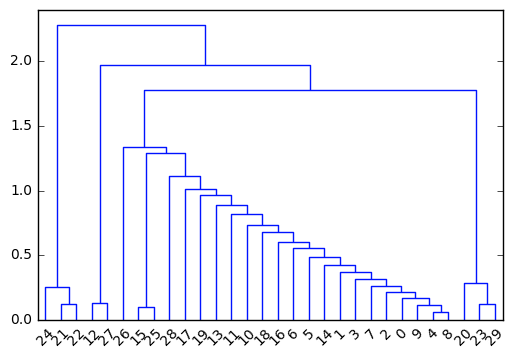

In [37]:
ttt, colorb = linkage_matrix(X=X_test)
N = X_test.shape[0]
Z1 = np.array(ttt)
Z1[:,2] = 1/Z1[:,2]
maxw = max(Z1[:,2])
Z1[Z1[:,2] < 0,2] = 2*maxw
for i in range(Z1.shape[0]):
    if Z1[i, 0] > (N-1):
        Z1[i, 2] += Z1[Z1[i, 0].astype("int")-N, 2]
    if Z1[i,1] > (N-1):
        Z1[i,2] += Z1[Z1[i,1].astype("int")-N, 2]

dendrogram(Z1,link_color_func=lambda k: colorb[k])
plt.show()
